NYU Center for Data Science

DS-GA 1003 Machine Learning

HW6 - Decision Trees and Boosting

Stephen Spivack (ss7726@nyu.edu)

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz
from IPython.display import Image
%matplotlib inline

### 1) Decision Tree Implementation

In this problem we’ll implement decision trees for both classification and regression. The strategy will be to implement a generic class, called `Decision_Tree`, which we’ll supply with the loss function we want to use to make node splitting decisions, as well as the estimator we’ll use to come up with the prediction associated with each leaf node. For classification, this prediction could be a vector of probabilities, but for simplicity we’ll just consider hard classifications here. We’ll work with the classification and regression data sets from previous assignments.

1) Complete the `compute_entropy` and compute `gini_functions`.

In [2]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    p_0 = len(np.argwhere(label_array==0))/label_array.shape[0]
    p_1 = len(np.argwhere(label_array==1))/label_array.shape[0]
    entropy = -np.sum(p_0*np.log2(p_0) + p_1*np.log2(p_1))
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    p_0 = len(np.argwhere(label_array==0))/label_array.shape[0]
    p_1 = len(np.argwhere(label_array==1))/label_array.shape[0]
    gini = 1 - (p_0*(1-p_0) + p_1*(1-p_1))
    return gini

2) Complete the class `Decision_Tree`, given in the skeleton code. The intended implementation is as follows: Each object of type `Decision_Tree` represents a single node of the tree. The depth of that node is represented by the variable self.depth, with the root node having depth 0. The main job of the fit function is to decide, given the data provided, how to split the node or whether it should remain a leaf node. If the node will split, then the splitting feature and splitting value are recorded, and the left and right subtrees are fit on the relevant portions of the data. Thus, tree-building is a recursive procedure. We should have as many `Decision_Tree` objects as there are nodes in the tree. We will not implement pruning here. Some additional details are given in the skeleton code.

In [3]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator, depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # create leaf node if <= min_sample OR if we are at max depth:
        if (y.shape[0] <= self.min_sample) or (self.depth == self.max_depth):
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        
        # compute best feature and value to split on:
        self.split_id, self.split_value = self.find_best_feature_split(x, y)
        if self.split_id is None:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        else:
            # compute indices for left samples and iteratively fit:
            left_idx = x[:, self.split_id] <= self.split_value
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, 
                                      self.min_sample, self.max_depth).fit(x[left_idx], y[left_idx])
            
            # compute indices for right samples and iteratively fit:
            right_idx = x[:, self.split_id] > self.split_value
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, self.depth+1, 
                                       self.min_sample, self.max_depth).fit(x[right_idx], y[right_idx])
        return self

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # sort x_node and y_node w.r.t x_node (feature values):
        x_node, y_node = x_node[np.argsort(x_node)], y_node[np.argsort(x_node)]
    
        # initialize best_loss and split_value:
        best_loss = float(np.inf)
        split_value = None
        
        # loop through each x-value:
        for i in range(1, len(x_node)):
            # compare current feature value to previous feature value:
            if x_node[i-1] != x_node[i]:
                # initialize left and right subsets:
                left_y = y_node[:i]
                right_y = y_node[i:]
                # compute loss for those subsets:
                left_loss = self.split_loss_function(left_y)
                right_loss = self.split_loss_function(right_y)
                # total loss as a weighted sum of the left_loss and right_loss:
                total_loss = len(left_y)*left_loss + len(right_y)*right_loss
                # update split value and loss if the total_loss is smaller:
                if total_loss < best_loss:
                    best_loss = total_loss
                    split_value = 0.5*(x_node[i-1] + x_node[i])
                    
        return split_value, best_loss

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Initialize best_feature_id, best_split_value and best_loss:
        best_feature_id, best_split_value, best_loss = None, None, float(np.inf)
        
        # loop through each x-value:
        for feature_id in range(x_node.shape[1]):
            # compute best split and loss:
            split_value, current_loss = self.find_best_split(x_node[:, feature_id], y_node, feature_id)
            # update best feature:
            if current_loss < best_loss:
                best_loss = current_loss
                best_feature_id = feature_id
                best_split_value = split_value
        
        return best_feature_id, best_split_value

    def predict_instance(self, instance):
        '''
        Predict label by decision tree
        
        :param instance: a numpy array with new data, shape (1, m)
        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

3) Run the code provided that builds trees for the two-dimensional classification data. Include the results. For debugging, you may want to compare results with sklearn’s decision tree (code provided in the skeleton code). For visualization, you’ll need to install `graphviz`.

In [4]:
# Load data
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

In [5]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [6]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

/var/folders/cj/3f7_kj156x73rd40g34116yc0000gn/T/ipykernel_38457/2142544210.py:10: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(p_0*np.log2(p_0) + p_1*np.log2(p_1))
/var/folders/cj/3f7_kj156x73rd40g34116yc0000gn/T/ipykernel_38457/2142544210.py:10: RuntimeWarning: invalid value encountered in double_scalars
  entropy = -np.sum(p_0*np.log2(p_0) + p_1*np.log2(p_1))


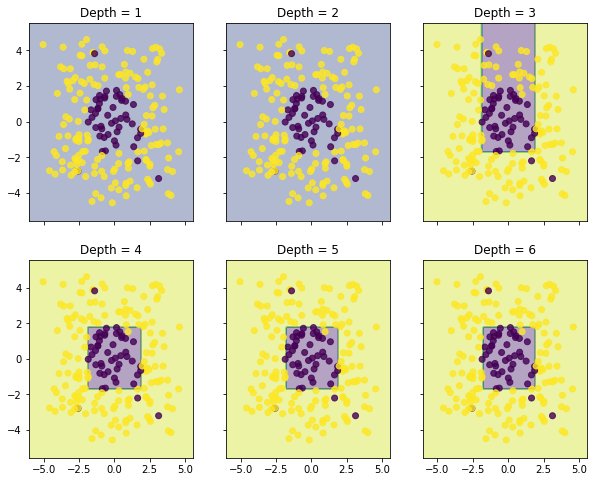

In [7]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

Comparison to sci-kit learn:

In [8]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

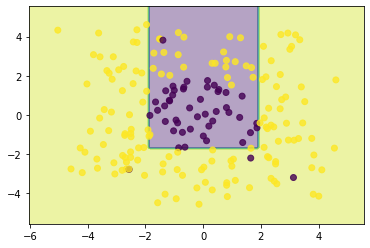

In [9]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

[Text(0.4583333333333333, 0.875, 'X[0] <= -1.862\nentropy = 0.795\nsamples = 200\nvalue = [48, 152]'),
 Text(0.25, 0.625, 'X[1] <= -2.77\nentropy = 0.129\nsamples = 56\nvalue = [1, 55]'),
 Text(0.16666666666666666, 0.375, 'X[1] <= -2.801\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(0.08333333333333333, 0.125, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.25, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3333333333333333, 0.375, 'entropy = 0.0\nsamples = 51\nvalue = [0, 51]'),
 Text(0.6666666666666666, 0.625, 'X[0] <= 1.917\nentropy = 0.911\nsamples = 144\nvalue = [47, 97]'),
 Text(0.5, 0.375, 'X[1] <= -1.688\nentropy = 0.998\nsamples = 97\nvalue = [46, 51]'),
 Text(0.4166666666666667, 0.125, 'entropy = 0.229\nsamples = 27\nvalue = [1, 26]'),
 Text(0.5833333333333334, 0.125, 'entropy = 0.94\nsamples = 70\nvalue = [45, 25]'),
 Text(0.8333333333333334, 0.375, 'X[1] <= -2.998\nentropy = 0.149\nsamples = 47\nvalue = [1, 46]'),
 Text(0.75, 0.125, 'entropy =

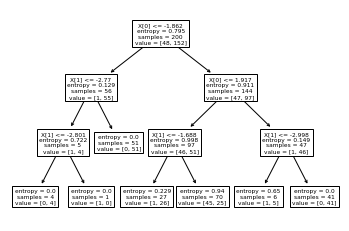

In [10]:
# Visualize decision tree
from sklearn import tree
tree.plot_tree(clf)

4) Complete the function `mean_absolute_deviation_around_median` (MAE). Use the code provided to fit the Regression Tree to the krr dataset using both the MAE loss and median predictions. Include the plots for the 6 fits.

In [11]:
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    mae = np.median(y - np.median(y))
    return mae

In [12]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

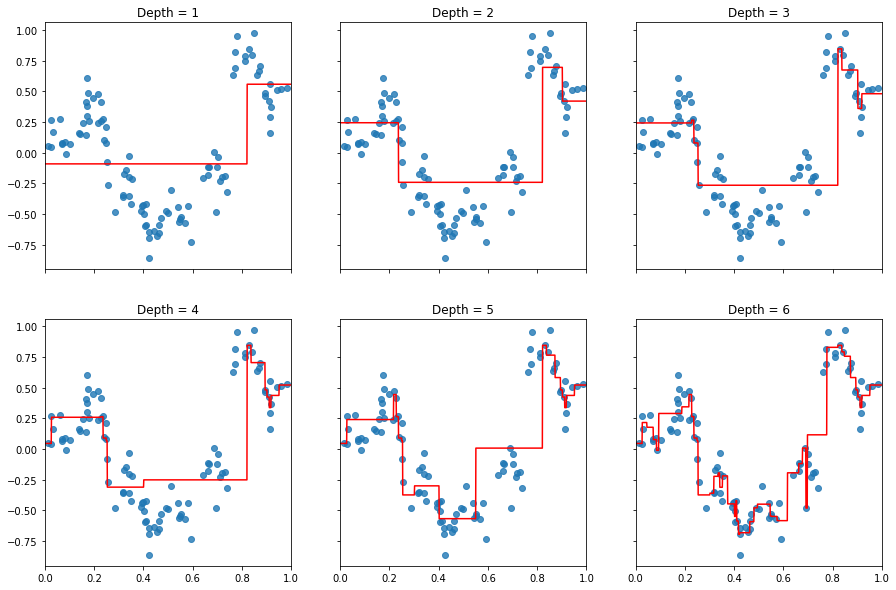

In [13]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

### 2) Ensembling

Recall the general gradient boosting algorithm, for a given loss function $\ell$ and a hypothesis space $F$ of regression functions (i.e. functions mapping from the input space to $\mathbb{R}$):

0: Initialize $f_0(x)=0$.

1: For m = 1 to M:

 - (a) Compute: $g_m = (\frac{\partial}{\partial f_{f_m - 1}(x_j)} \sum_{i+1}^n \ell (y_i, f_{m-1}(x_i)))_{j+1}^n$
    
 - (b) Fit regression model to $-g_m$: $h_m = argmin_{h \in F} \sum_{i=1}^n ((-g_m)_i - h(x_i))^2$
 
 - (c) Choose fixed step size $v_m = v \in (0,1]$, or take $v_m = argmin_{v>0} \sum_{i=1}^n \ell (y_i, f_{m-1} (x_i) + vh_m (x_i))$.
 
 - (d) Take the step: $f_m(x) = f_{m-1} (x) + v_m h_m(x)$
 
2: Return $f_M$.

$g_m = (\frac{\partial}{\partial f_{f_m - 1}(x_j)} \sum_{i+1}^n \ell (y_i, f_{m-1}(x_i)))_{j+1}^n$

This method goes by many names, including gradient boosting machines (GBM), generalized boosting models (GBM), AnyBoost, and gradient boosted regression trees (GBRT), among others. One of the nice aspects of gradient boosting is that it can be applied to any problem with a subdifferentiable loss function.

#### Gradient Boosting Regression Implementation

First we’ll keep things simple and consider the standard regression setting with square loss. In this case we have $Y = \mathbb{R}$, our loss function is given by $\ell(\hat{y}, y) = 1/2 (\hat{y} − y)^2$, and at the $m$’th round of gradient boosting, we have

$h_m = argmin_{h \in F} \sum_{i=1}^n [(y_i - f_{m-1}(x_i)) - h(x_i)]^2$

5) Complete the `gradient_boosting` class. As the base regression algorithm to compute the argmin, you should use sklearn’s regression tree. You should use the square loss for the tree splitting rule (`criterion` keyword argument) and use the default sklearn leaf prediction rule from the `predict` method. We will also use a constant step size $v$.

In [14]:
def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [15]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels 
            and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''

        train_predict = np.zeros(train_data.shape[0])
        for i in range(self.n_estimator):
            pseudo_residuals = self.pseudo_residual_func(train_target, train_predict)
            tree = DecisionTreeRegressor(criterion='squared_error', 
                                         min_samples_split=self.min_sample,
                                         max_depth=self.max_depth)
            tree.fit(train_data, pseudo_residuals)
            train_predict += self.learning_rate * tree.predict(train_data)
            self.estimators.append(tree)
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        test_predict = np.zeros(test_data.shape[0])
        for tree in self.estimators:
            test_predict += self.learning_rate * tree.predict(test_data)
        return test_predict

6) Run the code provided to build gradient boosting models on the regression data sets `krr-train.txt`, and include the plots generated. For debugging you can use the sklearn implementation of `GradientBoostingRegressor`.

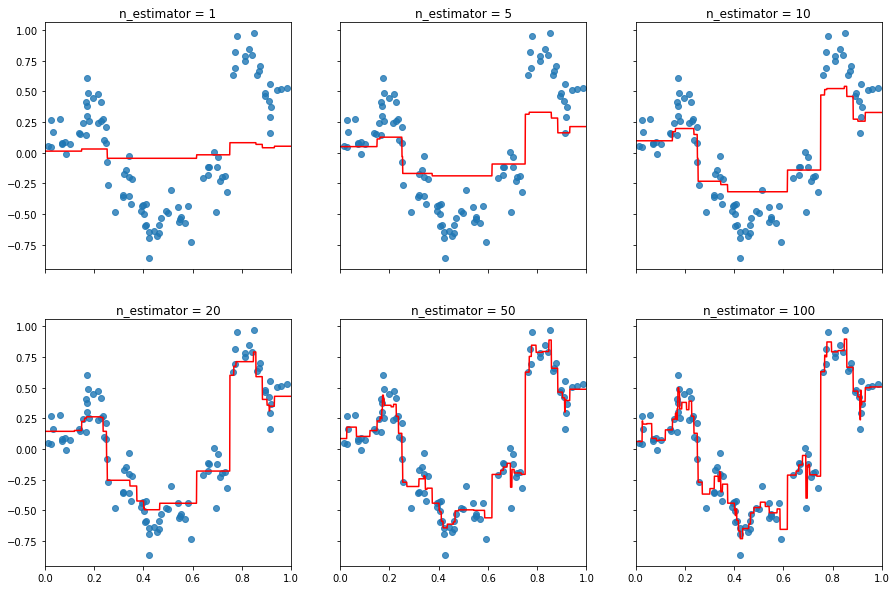

In [16]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

#### Classification of images with Gradient Boosting

In this problem we will consider the classification of MNIST, the dataset of handwritten digits images, with ensembles of trees. For simplicity, we only retain the ‘0’ and ’1’ examples and perform binary classification.

First we’ll derive a special case of the general gradient boosting framework: BinomialBoost. Let’s consider the classification framework, where $Y = {−1, 1}$. In lecture, we noted that AdaBoost corresponds to forward stagewise additive modeling with the exponential loss, and that the exponential loss is not very robust to outliers (i.e. outliers can have a large effect on the final prediction function). Instead, let’s consider the logistic loss

$\ell(m) = ln(1 + e^{-m}),$

where $m = yf(x)$ is the margin.

7) Give the expression of the negative gradient step direction, or pseudo residual, $−g_m$ for the logistic loss as a function of the prediction function $f_{m-1}$ at the previous iteration and the dataset points ${(x_i,y_i)}_{i=1}^n$. What is the dimension of $g_m$?

$-g_m = r_i = -\frac{\partial}{\partial f(x_i)} [log(1 + e^{-y_i f(x_i)})] = \frac{y_i}{1 + e^y_i f(x_i)}$

The dimension of $g_m = n$.

8) Write an expression for $h_m$ as an argmin over functions $h$ in $F$.

$h_m = argmin_{h \in H} \sum_{i=1}^n [(\frac{y_i}{1 + e^{y_i f_{m-1}(x_i)}}) - h(x_i)]^2$

9) Load the MNIST dataset using the helper preprocessing function in the skeleton code. Using the scikit learn implementation of `GradientBoostingClassifier`, with the logistic loss `(loss=‘deviance’)` and trees of maximum depth 3, fit the data with 2, 5, 10, 100 and 200 iterations (estimators). Plot the train and test accurary as a function of the number of estimators.

In [17]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

In [19]:
num_estimators = [2, 5, 10, 100, 200]
train_accuracy = []
test_accuracy = []
for i in range(len(num_estimators)):
    clf = GradientBoostingClassifier(loss='deviance', 
                                     max_depth=3, 
                                     n_estimators=num_estimators[i]).fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    train_accuracy.append(len(np.argwhere(train_predictions==y_train).flatten())/len(y_train))
    test_predictions = clf.predict(X_test)
    test_accuracy.append(len(np.argwhere(test_predictions==y_test).flatten())/len(y_test))

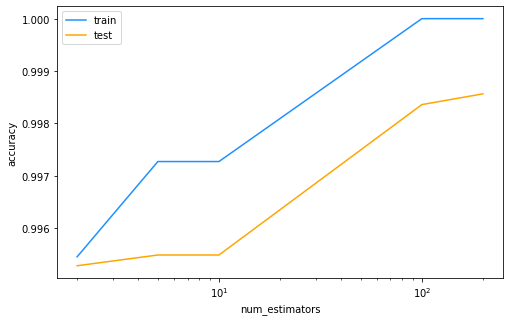

In [20]:
plt.figure(figsize=(8,5))
plt.plot(num_estimators, train_accuracy, color='dodgerblue', label='train')
plt.plot(num_estimators, test_accuracy, color='orange', label='test')
plt.legend()
plt.xscale('log')
plt.xlabel('num_estimators')
plt.ylabel('accuracy')
plt.show()

#### Classification of images with Random Forests

10) Another type of ensembling method we discussed in class are random forests. Explain in your own words the construction principle of random forests.

Random forests are an ensemble method where multiple decision trees are built and combined. Each decision tree is trained on a random subset of the original data (bagging). To ensure that trees are uncorrelated, a random subset of features (usually $\sqrt d$) is selected at each split. In the classification setting, outputs are combined via majority voting; in the regression setting, outputs are simply averaged over.

11) Using the scikit learn implementation of `RandomForestClassifier`, with the entropy loss `(criterion=‘entropy’)` and trees of maximum depth 3, fit the preprocessed binary MNIST dataset with 2, 5, 10, 50, 100 and 200 estimators.

In [21]:
num_estimators = [2, 5, 10, 100, 200]
train_accuracy = []
test_accuracy = []
for i in range(len(num_estimators)):
    clf = RandomForestClassifier(criterion='entropy', 
                                 max_depth=3, 
                                 n_estimators=num_estimators[i]).fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    train_accuracy.append(len(np.argwhere(train_predictions==y_train).flatten())/len(y_train))
    test_predictions = clf.predict(X_test)
    test_accuracy.append(len(np.argwhere(test_predictions==y_test).flatten())/len(y_test))

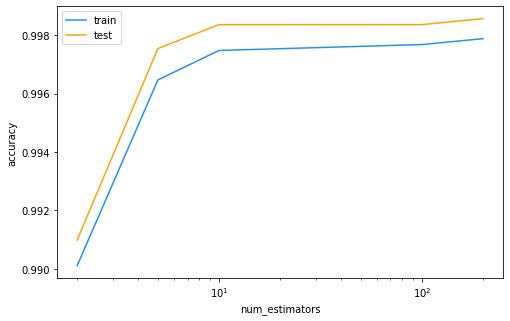

In [22]:
plt.figure(figsize=(8,5))
plt.plot(num_estimators, train_accuracy, color='dodgerblue', label='train')
plt.plot(num_estimators, test_accuracy, color='orange', label='test')
plt.legend()
plt.xscale('log')
plt.xlabel('num_estimators')
plt.ylabel('accuracy')
plt.show()

12) What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees? Which method achieves the best train accuracy overall? Is this result expected? Can you think of a practical disadvantage of the best performing method? How do the algorithms compare in term of test accuracy?

In a random forest, multiple trees are trained and combined according to the ensemble method described above. Gradient boosted trees, on the other hand, are trained sequentially by fitting trees to the residuals of the previous ones which results in higher training accuracy compared to random forests, as expected. The disadvantage is that risk of overfitting is greater. In terms of test accuracy, random forests tend to perform better.